In [118]:
import pandas as pd
from pathlib import Path

### MEARGING ALL THE SHEETS AND CONVERTING TO CSV

In [119]:
def combine_excel_sheets_to_csv_corrected(excel_file_path, output_csv_path):
    try:
        print("Reading first sheet to get header...")
        df_header_data = pd.read_excel(excel_file_path, sheet_name=0, header=0)

        column_names = df_header_data.columns.tolist()
        print(f"Extracted headers: {column_names}")

        data_to_combine = [df_header_data]

        print("Processing subsequent sheets (data only)...")

        xls = pd.ExcelFile(excel_file_path)
        sheet_names = xls.sheet_names

        for i, sheet_name in enumerate(sheet_names[1:], start=2):

            df_data = pd.read_excel(
                excel_file_path,
                sheet_name=sheet_name,
                header=None
            )

            if len(df_data.columns) == len(column_names):
                df_data.columns = column_names
                data_to_combine.append(df_data)
                print(f"Sheet {i} ('{sheet_name}'): Added {len(df_data)} rows.")
            else:
                print(f"Warning: Sheet {i} ('{sheet_name}') has {len(df_data.columns)} columns, but header expects {len(column_names)}. Skipping.")

        if data_to_combine:
            combined_df = pd.concat(data_to_combine, ignore_index=True)
            print(f"\nSuccessfully combined {len(data_to_combine)} sheets.")
            print(f"Total rows in combined data: {len(combined_df)}")

            combined_df.to_csv(output_csv_path, index=False)
            print(f"\nSuccess! Data saved to: {output_csv_path}")
        else:
            print("Error: No data sheets were processed.")
            return
    except FileNotFoundError:
        print(f"Error: The file was not found at {excel_file_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [120]:
EXCEL_FILE = 'right eye open_1.xlsx'
OUTPUT_FILE = 'combined_data.csv'

raw_path = Path("./Data_raw").resolve()

combine_excel_sheets_to_csv_corrected(raw_path / EXCEL_FILE, raw_path / OUTPUT_FILE)

Reading first sheet to get header...
Extracted headers: ['Fp1-A1', 'Fp2-A2', 'F3-A1', 'F4-A2', 'C3-A1', 'C4-A2', 'P3-A1', 'P4-A2', 'O1-A1', 'O2-A2', 'F7-A1', 'F8-A2', 'T3-A1', 'T4-A2', 'T5-A1', 'T6-A2', 'Fz-Aav', 'Cz-Aav', 'Pz-Aav', 'T1-A1', 'T2-A2']
Processing subsequent sheets (data only)...
Sheet 2 ('Sheet2'): Added 30000 rows.
Sheet 3 ('Sheet3'): Added 30000 rows.
Sheet 4 ('Sheet4'): Added 30000 rows.

Successfully combined 4 sheets.
Total rows in combined data: 259500

Success! Data saved to: /home/deruka/code-playground/CNN-LSTM/Data_raw/combined_data.csv


### HARMONIZING EEG STRUCTURE

In [121]:
def harmonize_eeg_structure(input_csv, output_csv):
    df = pd.read_csv(input_csv)

    df.columns = [str(c).split('-')[0].strip() for c in df.columns]

    name_mapping = {
        'T7': 'T3', 'T8': 'T4', 
        'P7': 'T5', 'P8': 'T6'
    }
    df.rename(columns=name_mapping, inplace=True)

    standard_19 = [
        'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
        'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
    ]

    harmonized_df = pd.DataFrame()
    for chan in standard_19:
        if chan in df.columns:
            harmonized_df[chan] = df[chan]
        else:
            print(f"Warning: Channel {chan} missing. Filling with zeros.")
            harmonized_df[chan] = 0.0

    harmonized_df.to_csv(output_csv, index=False)
    print(f"Harmonization Complete: {output_csv} saved with {len(harmonized_df.columns)} channels.")

    return harmonized_df

In [122]:
INPUT_FILE = 'combined_data.csv'
OUPUT_FILE = 'harmonized_data.csv'

harmonized_df = harmonize_eeg_structure(raw_path / INPUT_FILE, raw_path / OUPUT_FILE)

Harmonization Complete: /home/deruka/code-playground/CNN-LSTM/Data_raw/harmonized_data.csv saved with 19 channels.


### FIRST CLEANUP

In [123]:
def clean_csv_zeros_and_save(input_csv_path, output_csv_path, batch_size=100000):
    try:
        print(f"Reading data in batches from: {input_csv_path}")
        
        first_chunk = True
        original_rows = 0
        cleaned_rows = 0

        for df in pd.read_csv(input_csv_path, low_memory=False, chunksize=batch_size):
            original_rows += len(df)

            # FIX: select all numeric EEG columns safely
            numeric_cols = df.select_dtypes(include='number').columns

            # Enforce numeric
            df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

            # Drop rows that are fully NaN across EEG channels
            df.dropna(subset=numeric_cols, how='all', inplace=True)

            # Remove rows that are all-zero across EEG channels
            has_non_zero = df[numeric_cols].ne(0).any(axis=1)
            df_cleaned = df.loc[has_non_zero]

            cleaned_rows += len(df_cleaned)

            if first_chunk:
                df_cleaned.to_csv(output_csv_path, index=False, mode='w')
                first_chunk = False
            else:
                df_cleaned.to_csv(output_csv_path, index=False, mode='a', header=False)

        print("\n--- Cleaning Summary ---")
        print(f"Original Rows: {original_rows}")
        print(f"Cleaned Rows: {cleaned_rows}")
        print(f"Total Rows Removed: {original_rows - cleaned_rows}")
        print(f"\nSuccess! Cleaned data saved to: {output_csv_path}")

    except FileNotFoundError:
        print(f"Error: The file was not found at {input_csv_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [124]:
INPUT_FILE = 'harmonized_data.csv'
OUPUT_FILE = 'cleaned_data.csv'

processed_path = Path("./Data_processed").resolve()

clean_csv_zeros_and_save(raw_path / INPUT_FILE, processed_path / OUPUT_FILE)

Reading data in batches from: /home/deruka/code-playground/CNN-LSTM/Data_raw/harmonized_data.csv

--- Cleaning Summary ---
Original Rows: 259500
Cleaned Rows: 258787
Total Rows Removed: 713

Success! Cleaned data saved to: /home/deruka/code-playground/CNN-LSTM/Data_processed/cleaned_data.csv


### HANDLING OUTLIERS

In [125]:
import numpy as np

In [126]:
def handle_outliers_iqr(input_csv_path, output_csv_path, threshold=1.5, batch_size=100000):
    try:
        print(f"Analyzing data types and calculating statistics from: {input_csv_path}")
        
        sample_df = pd.read_csv(input_csv_path, nrows=100)
        numerical_cols = sample_df.select_dtypes(include='number').columns.tolist()

        if not numerical_cols:
            print("Error: No numerical columns found.")
            return

        # --- Compute global IQR bounds safely ---
        stats_df = pd.read_csv(input_csv_path, usecols=numerical_cols)
        stats_df[numerical_cols] = stats_df[numerical_cols].apply(
            pd.to_numeric, errors='coerce'
        )

        bounds = {}
        for col in numerical_cols:
            Q1 = stats_df[col].quantile(0.25)
            Q3 = stats_df[col].quantile(0.75)
            IQR = Q3 - Q1
            bounds[col] = (Q1 - threshold * IQR, Q3 + threshold * IQR)

        del stats_df

        print(f"Applying outlier capping in batches of {batch_size}...")
        first_chunk = True
        original_rows = 0
        outlier_count = 0

        for chunk in pd.read_csv(input_csv_path, chunksize=batch_size):
            original_rows += len(chunk)

            # FIX: enforce numeric per chunk
            chunk[numerical_cols] = chunk[numerical_cols].apply(
                pd.to_numeric, errors='coerce'
            )

            for col, (lower, upper) in bounds.items():
                low_mask = chunk[col] < lower
                high_mask = chunk[col] > upper
                outlier_count += low_mask.sum() + high_mask.sum()

                chunk.loc[low_mask, col] = lower
                chunk.loc[high_mask, col] = upper

            if first_chunk:
                chunk.to_csv(output_csv_path, index=False, mode='w')
                first_chunk = False
            else:
                chunk.to_csv(output_csv_path, index=False, mode='a', header=False)

        print("\n--- Outlier Handling Summary ---")
        print(f"Original Rows: {original_rows}")
        print(f"Total Outlier Values Capped: {outlier_count}")
        print(f"Success! Data saved to: {output_csv_path}")

    except FileNotFoundError:
        print(f"Error: File not found at {input_csv_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [127]:
INPUT_FILE = 'cleaned_data.csv'
OUTPUT_FILE = 'outliers_handled_data.csv'

handle_outliers_iqr(processed_path / INPUT_FILE, processed_path / OUTPUT_FILE)

Analyzing data types and calculating statistics from: /home/deruka/code-playground/CNN-LSTM/Data_processed/cleaned_data.csv
Applying outlier capping in batches of 100000...

--- Outlier Handling Summary ---
Original Rows: 258787
Total Outlier Values Capped: 75193
Success! Data saved to: /home/deruka/code-playground/CNN-LSTM/Data_processed/outliers_handled_data.csv


### KDE COMPARISION FOR CHANNEL **O1** AND **O2**

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

In [129]:
def plot_eeg_difference_kde_display(before_file, after_file):
    COLUMNS_TO_PLOT = ['O1', 'O2']
    try:
        df_before = pd.read_csv(before_file, usecols=COLUMNS_TO_PLOT)
        df_after = pd.read_csv(after_file, usecols=COLUMNS_TO_PLOT)

        if len(df_before) > 50000:
            df_before = df_before.sample(n=50000, random_state=42)
            df_after = df_after.sample(n=50000, random_state=42)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        color_before = 'red'
        color_after = 'green'

        for i, col in enumerate(COLUMNS_TO_PLOT):
            ax = axes[i]
            
            sns.kdeplot(
                df_before[col], 
                ax=ax, 
                color=color_before, 
                label='Before', 
                fill=True, 
                alpha=0.3, 
                linewidth=2
            )
            
            sns.kdeplot(
                df_after[col], 
                ax=ax, 
                color=color_after, 
                label='After', 
                fill=False, 
                linewidth=2
            )
            
            ax.set_title(f'KDE Comparison: {col}')
            ax.set_xlabel('Voltage')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(axis='y', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()
        plt.close(fig)
    except Exception as e:
        print(f"Error: {e}")

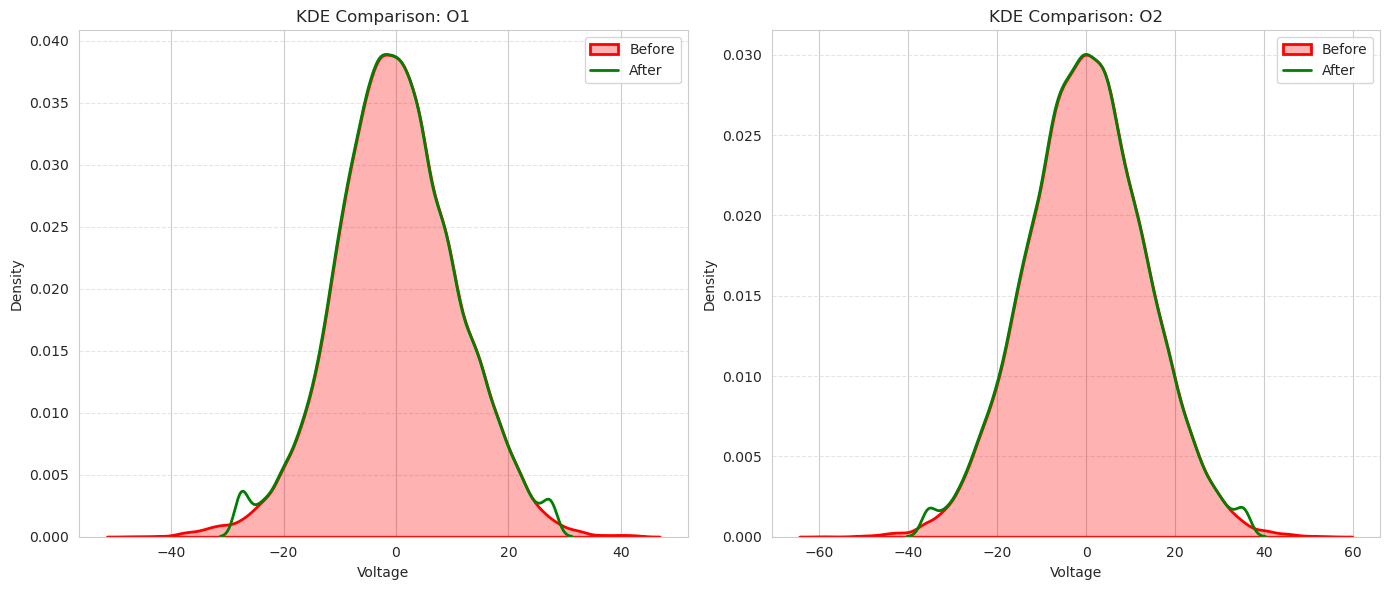

In [130]:
INPUT_FILE_BEFORE = 'cleaned_data.csv'
INPUT_FILE_AFTER = 'outliers_handled_data.csv'

plot_eeg_difference_kde_display(processed_path / INPUT_FILE_BEFORE, processed_path / INPUT_FILE_AFTER)

### ELLIPTICAL BANDPASS FILTERING

In [131]:
from scipy.signal import ellip, butter, sosfilt, lfilter, lfilter_zi, sosfilt_zi

In [132]:
FS = 125.0
LOW_CUTOFF = 3.0
HIGH_CUTOFF = 13.0
FILTER_ORDER = 4
NOTCH_FREQUENCY = 50.0

In [133]:
def process_and_filter_eeg_batches(
    input_file,
    output_file,
    fs=FS,
    low_c=LOW_CUTOFF,
    high_c=HIGH_CUTOFF,
    notch_f=NOTCH_FREQUENCY,
    batch_size=100000
):
    try:
        sample_df = pd.read_csv(input_file, nrows=10)
        eeg_cols = sample_df.select_dtypes(include='number').columns.tolist()

        nyquist = 0.5 * fs

        sos_ellip = ellip(
            N=FILTER_ORDER,
            rp=0.5,
            rs=40.0,
            Wn=[low_c / nyquist, high_c / nyquist],
            btype='bandpass',
            output='sos'
        )

        b_notch, a_notch = butter(
            2,
            [(notch_f - 1) / nyquist, (notch_f + 1) / nyquist],
            btype='bandstop'
        )

        sos_states = {col: sosfilt_zi(sos_ellip) for col in eeg_cols}
        notch_states = {col: lfilter_zi(b_notch, a_notch) for col in eeg_cols}

        first_chunk = True
        for chunk in pd.read_csv(input_file, chunksize=batch_size):

            # FIX: enforce numeric before filtering
            chunk[eeg_cols] = chunk[eeg_cols].apply(
                pd.to_numeric, errors='coerce'
            )

            for col in eeg_cols:
                chunk[col], sos_states[col] = sosfilt(
                    sos_ellip, chunk[col].values, zi=sos_states[col]
                )

                chunk[col], notch_states[col] = lfilter(
                    b_notch, a_notch, chunk[col].values, zi=notch_states[col]
                )

            if first_chunk:
                chunk.to_csv(output_file, index=False, mode='w')
                first_chunk = False
            else:
                chunk.to_csv(output_file, index=False, mode='a', header=False)

        print(f"Success! Batch filtered data saved to: {output_file}")

    except Exception as e:
        print(f"Error: {e}")

In [134]:
INPUT_FILE = 'outliers_handled_data.csv'
OUTPUT_FILE = 'filtered_data_elliptical.csv'

process_and_filter_eeg_batches(processed_path / INPUT_FILE, processed_path / OUTPUT_FILE)

Success! Batch filtered data saved to: /home/deruka/code-playground/CNN-LSTM/Data_processed/filtered_data_elliptical.csv


### EEG COMPARISION OF BEFORE AND AFTER FILTERING FOR CHANNEL **O1** AND **O2**

In [135]:
def plot_filtering_comparison(before_file, after_file, max_samples=500):
    CHANNELS_TO_PLOT = ['O1', 'O2']

    try:
        print(f"Loading first {max_samples} samples from visual channels...")

        df_before = pd.read_csv(before_file, usecols=CHANNELS_TO_PLOT, nrows=max_samples)
        df_after = pd.read_csv(after_file, usecols=CHANNELS_TO_PLOT, nrows=max_samples)

        df_before['Sample Index'] = df_before.index
        df_after['Sample Index'] = df_after.index

        df_before['Treatment'] = 'Before Filtering (Raw)'
        df_after['Treatment'] = 'After Filtering (Bandpass + Notch)'

        cols_to_combine = CHANNELS_TO_PLOT + ['Treatment', 'Sample Index']

        df_combined = pd.concat([df_before[cols_to_combine],
                                 df_after[cols_to_combine]], ignore_index=True)

        df_plot = pd.melt(df_combined,
                          id_vars=['Sample Index', 'Treatment'],
                          value_vars=CHANNELS_TO_PLOT,
                          var_name='Channel',
                          value_name='Voltage')

        fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
        plt.suptitle(f'EEG Filtering Comparison: First {max_samples} Samples', fontsize=16)

        custom_palette = {'Before Filtering (Raw)': 'red', 'After Filtering (Bandpass + Notch)': 'blue'}

        for i, col in enumerate(CHANNELS_TO_PLOT):
            ax = axes[i]
            df_channel = df_plot[df_plot['Channel'] == col]

            sns.lineplot(
                x='Sample Index',
                y='Voltage',
                hue='Treatment',
                data=df_channel,
                ax=ax,
                palette=custom_palette,
                linewidth=1,
                alpha=0.8
            )

            ax.set_title(f'Channel: {col}')
            ax.set_ylabel('Voltage ($\mu$V)')
            ax.grid(axis='y', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()
        plt.close(fig)
    except Exception as e:
        print(f"Error during plotting: {e}")

Loading first 500 samples from visual channels...


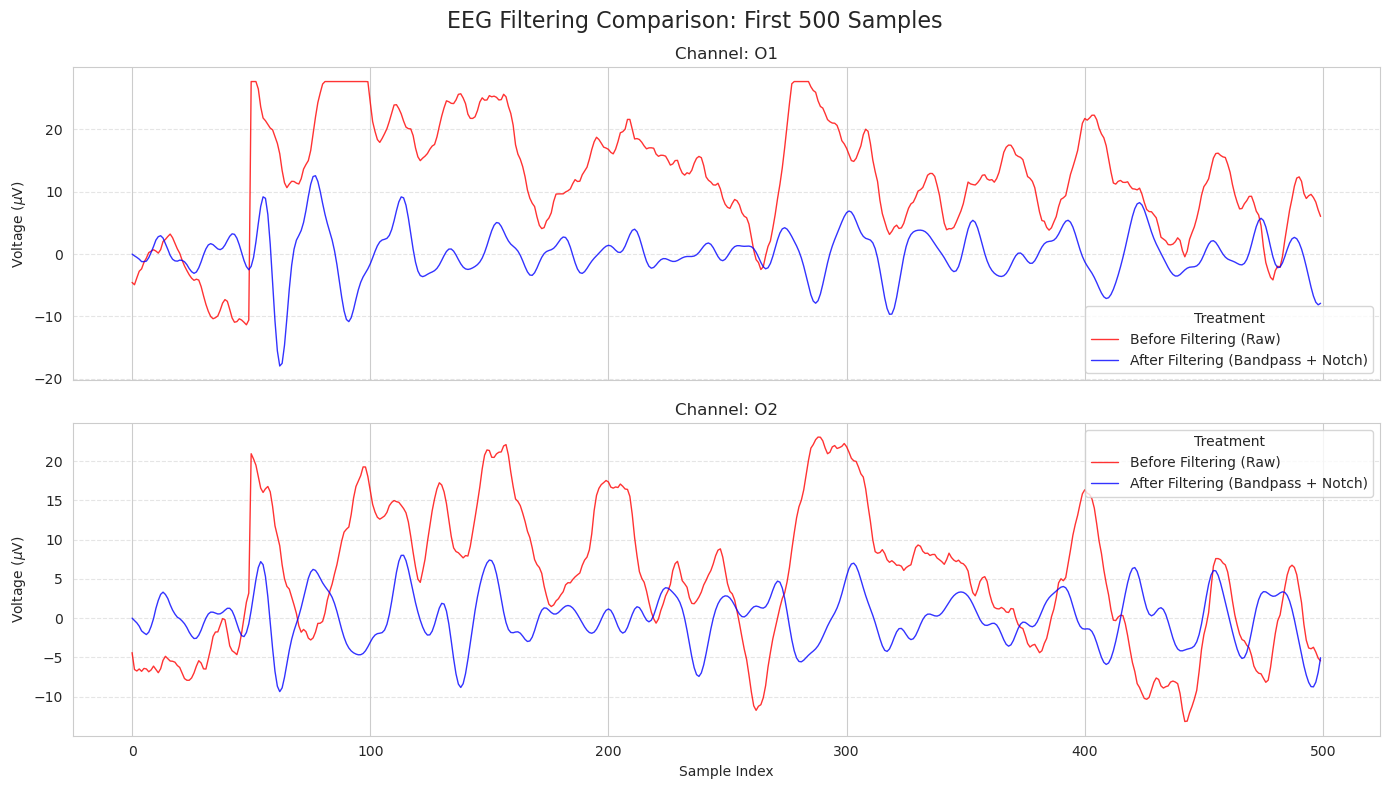

In [136]:
INPUT_FILE_BEFORE = 'outliers_handled_data.csv'
INPUT_FILE_AFTER = 'filtered_data_elliptical.csv'

plot_filtering_comparison(processed_path / INPUT_FILE_BEFORE, processed_path / INPUT_FILE_AFTER)

### ARTIFACT REMOVAL USING ICA

In [137]:
import mne
import scipy

In [138]:
def apply_ica_artifact_removal(input_file, output_file, sfreq=FS):
    try:
        df = pd.read_csv(input_file)

        eeg_cols = df.select_dtypes(include='number').columns.tolist()
        df[eeg_cols] = df[eeg_cols].apply(pd.to_numeric, errors='coerce')

        # Convert to MNE format (Volts)
        data_mne = df[eeg_cols].values.T * 1e-6

        info = mne.create_info(
            ch_names=eeg_cols,
            sfreq=sfreq,
            ch_types=['eeg'] * len(eeg_cols)
        )

        raw = mne.io.RawArray(data_mne, info, verbose=False)
        raw.set_eeg_reference('average', projection=False, verbose=False)

        # FIX: ensure ICA components do not exceed channel rank
        n_components = min(15, len(eeg_cols) - 1)

        ica = mne.preprocessing.ICA(
            n_components=n_components,
            random_state=42,
            method='picard',
            max_iter='auto'
        )

        ica.fit(raw, decim=3)

        ica_sources = ica.get_sources(raw).get_data()
        kurtosis_values = [scipy.stats.kurtosis(src) for src in ica_sources]

        artifact_idx = int(np.argmax(kurtosis_values))
        ica.exclude = [artifact_idx]

        print(
            f"DEBUG: Component {artifact_idx} had highest kurtosis "
            f"({max(kurtosis_values):.2f}). Excluding it."
        )

        raw_cleaned = ica.apply(raw, verbose=False)
        cleaned_data = raw_cleaned.get_data().T * 1e6  # back to µV

        df[eeg_cols] = cleaned_data
        df.to_csv(output_file, index=False)

        print(f"ICA complete. Cleaned data saved to {output_file}")

    except Exception as e:
        print(f"Error in ICA logic: {e}")

In [139]:
INPUT_FILE = 'filtered_data_elliptical.csv'
OUTPUT_FILE = 'ica_cleaned_data.csv'

apply_ica_artifact_removal(processed_path / INPUT_FILE, processed_path / OUTPUT_FILE)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components


/tmp/ipykernel_3271/2858685538.py:30: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, decim=3)


Fitting ICA took 3.8s.
DEBUG: Component 0 had highest kurtosis (2.40). Excluding it.
ICA complete. Cleaned data saved to /home/deruka/code-playground/CNN-LSTM/Data_processed/ica_cleaned_data.csv


### ICA ARTIFACT REMOVAL COMAPRISION BEFORE AND AFTER FOR **O1** AND **O2**

In [140]:
def plot_ica_comparison(before_file, after_file, window_size=500):
    CHANNELS_TO_PLOT = ['O1', 'O2']
    
    try:
        df_before_full = pd.read_csv(before_file, usecols=CHANNELS_TO_PLOT, nrows=5000)
        df_after_full = pd.read_csv(after_file, usecols=CHANNELS_TO_PLOT, nrows=5000)

        diff = (df_before_full[CHANNELS_TO_PLOT] - df_after_full[CHANNELS_TO_PLOT]).abs().sum(axis=1)

        max_diff_idx = diff.idxmax()
        start = max(0, max_diff_idx - (window_size // 2))
        end = start + window_size
        
        print(f"Significant ICA change detected near sample {max_diff_idx}. Plotting window {start}:{end}")

        df_before = df_before_full.iloc[start:end].copy()
        df_after = df_after_full.iloc[start:end].copy()
        
        df_before['Sample Index'] = df_before.index
        df_after['Sample Index'] = df_after.index
        df_before['Treatment'] = 'Before ICA'
        df_after['Treatment'] = 'After ICA'

        df_combined = pd.concat([df_before, df_after], ignore_index=True)
        df_plot = pd.melt(df_combined, id_vars=['Sample Index', 'Treatment'], 
                          value_vars=CHANNELS_TO_PLOT, var_name='Channel', value_name='Voltage')

        fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
        custom_palette = {'Before ICA': 'royalblue', 'After ICA': 'darkorange'}

        for i, col in enumerate(CHANNELS_TO_PLOT):
            sns.lineplot(x='Sample Index', y='Voltage', hue='Treatment', 
                         data=df_plot[df_plot['Channel'] == col], ax=axes[i], 
                         palette=custom_palette, linewidth=1.5)
            axes[i].set_title(f'Channel: {col} (Max Change Window)')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

Significant ICA change detected near sample 2525. Plotting window 2275:2775


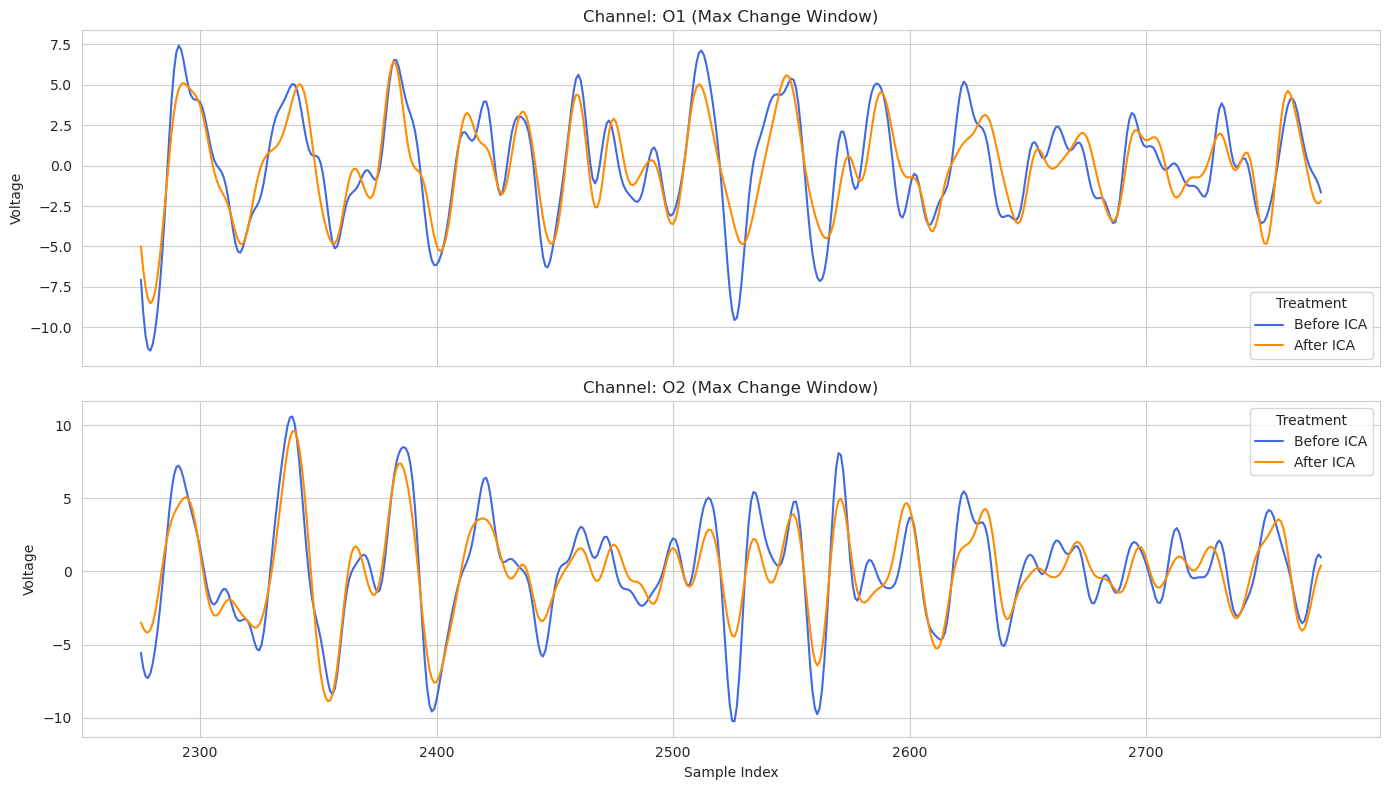

In [141]:
INPUT_FILE_BEFORE = 'filtered_data_elliptical.csv'
INPUT_FILE_AFTER = 'ica_cleaned_data.csv'

plot_ica_comparison(processed_path / INPUT_FILE_BEFORE, processed_path / INPUT_FILE_AFTER)

### EXTRACTING RANDOM 20K DATA

In [142]:
def separate_20k_middle_window(input_file, window_file, training_file, window_size=20000):
    try:
        df = pd.read_csv(input_file)
        total_rows = len(df)

        if total_rows < window_size:
            raise ValueError(
                f"Dataset too small ({total_rows} rows) for requested "
                f"window_size={window_size}."
            )

        start_idx = (total_rows // 2) - (window_size // 2)
        start_idx = max(0, start_idx)
        end_idx = start_idx + window_size

        df_window = df.iloc[start_idx:end_idx].copy()
        df_window.to_csv(window_file, index=False)

        df_remaining = df.drop(df.index[start_idx:end_idx])
        df_remaining.to_csv(training_file, index=False)

        print(f"Middle Window (Rows {start_idx} to {end_idx}) saved to: {window_file}")
        print(f"Remaining data ({len(df_remaining)} rows) saved to: {training_file}")

    except Exception as e:
        print(f"Error during separation: {e}")

In [143]:
INPUT_FILE = 'ica_cleaned_data.csv'
OUTPUT_FILE_WINDOW = 'ica_window_20k.csv'
OUTPUT_FILE_TRAINING = 'ica_training.csv'

separate_20k_middle_window(
    processed_path / INPUT_FILE,
    processed_path / OUTPUT_FILE_WINDOW,
    processed_path / OUTPUT_FILE_TRAINING
)

Middle Window (Rows 119393 to 139393) saved to: /home/deruka/code-playground/CNN-LSTM/Data_processed/ica_window_20k.csv
Remaining data (238787 rows) saved to: /home/deruka/code-playground/CNN-LSTM/Data_processed/ica_training.csv


### PSD FEATURE EXTRACTION

In [144]:
from scipy.signal import welch

In [145]:
def calculate_band_power(freqs, psd, band):
    low, high = band
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    band_power = np.trapezoid(psd[idx_band], freqs[idx_band])
    return band_power

def calculate_psd_features(input_file, output_file, fs, segment_len_sec, bands):
    try:
        print(f"Loading data from: {input_file}")
        df = pd.read_csv(input_file)

        df.columns = [str(col) for col in df.columns]
        eeg_df = df.select_dtypes(include=np.number)
        channel_names = eeg_df.columns.tolist()

        nperseg = int(segment_len_sec * fs)
        all_psd_features = []

        print(f"Calculating PSD and Relative Power (NPERSEG={nperseg})...")

        for col in channel_names:
            signal = eeg_df[col].values

            freqs, psd = welch(
                signal,
                fs=fs,
                nperseg=nperseg,
                window='hann',
                scaling='density'
            )

            channel_features = {'Channel': col}

            total_idx = np.logical_and(freqs >= 0.5, freqs <= 45.0)
            total_power = np.trapezoid(psd[total_idx], freqs[total_idx])

            for band_name, band_range in bands.items():
                abs_power = calculate_band_power(freqs, psd, band_range)

                channel_features[f'{band_name}_Abs'] = abs_power

                channel_features[f'{band_name}_Rel'] = abs_power / total_power if total_power > 0 else 0

            all_psd_features.append(channel_features)

        psd_df = pd.DataFrame(all_psd_features)
        psd_df.to_csv(output_file, index=False)

        print(f"\nSuccess! PSD features (Abs & Rel) saved to: {output_file}")
        return psd_df
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [146]:
INPUT_FILE = 'ica_window_20k.csv'
OUTPUT_FILE = 'psd_features.csv'

SEGMENT_LENGTH_SECONDS = 2.0

EEG_BANDS = {
    'Theta': [4.0, 8.0],
    'Alpha': [8.0, 13.0]
}

psd_features = calculate_psd_features(
    input_file=processed_path / INPUT_FILE,
    output_file=processed_path / OUTPUT_FILE,
    fs=FS,
    segment_len_sec=SEGMENT_LENGTH_SECONDS,
    bands=EEG_BANDS
)

Loading data from: /home/deruka/code-playground/CNN-LSTM/Data_processed/ica_window_20k.csv
Calculating PSD and Relative Power (NPERSEG=250)...

Success! PSD features (Abs & Rel) saved to: /home/deruka/code-playground/CNN-LSTM/Data_processed/psd_features.csv


### PSD ANALYSIS FOR CHANNEL **O1** AND **O2**

In [147]:
def plot_psd(input_file, fs=FS, nperseg=int(FS * 2)):
    try:
        df = pd.read_csv(input_file)
        
        fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        sns.set_style("whitegrid")
        
        bands = {
            'Theta (4-8Hz)':  [4.0, 8.0, 'green'],
            'Alpha (8-13Hz)': [8.0, 13.0, 'blue'],
        }

        channels_to_plot = ['O1', 'O2']
        colors = ['#E63946', '#1D3557']
        
        for i, col in enumerate(channels_to_plot):
            if col not in df.columns:
                print(f"Warning: Channel {col} not found.")
                continue
                
            ax = axes[i]
            signal = df[col].values

            freqs, psd = welch(signal, fs=fs, nperseg=nperseg, window='hann', scaling='density')

            for name, (low, high, color) in bands.items():
                ax.axvspan(low, high, color=color, alpha=0.1, label=name)

            ax.plot(freqs, psd, color=colors[i], linewidth=2.5)

            ax.set_title(f'PSD Analysis: {col}', fontsize=14, fontweight='bold')
            ax.set_xlim([0, 30])
            ax.set_ylim(bottom=0)
            ax.set_ylabel(r'Power ($\mu V^2 / Hz$)', fontsize=12)
            ax.grid(True, which="both", ls="--", alpha=0.5)

            ax.legend(loc='upper right')

        plt.xlabel('Frequency (Hz)', fontsize=13)
        plt.tight_layout()

        plt.show()

    except Exception as e:
        print(f"Error: {e}")

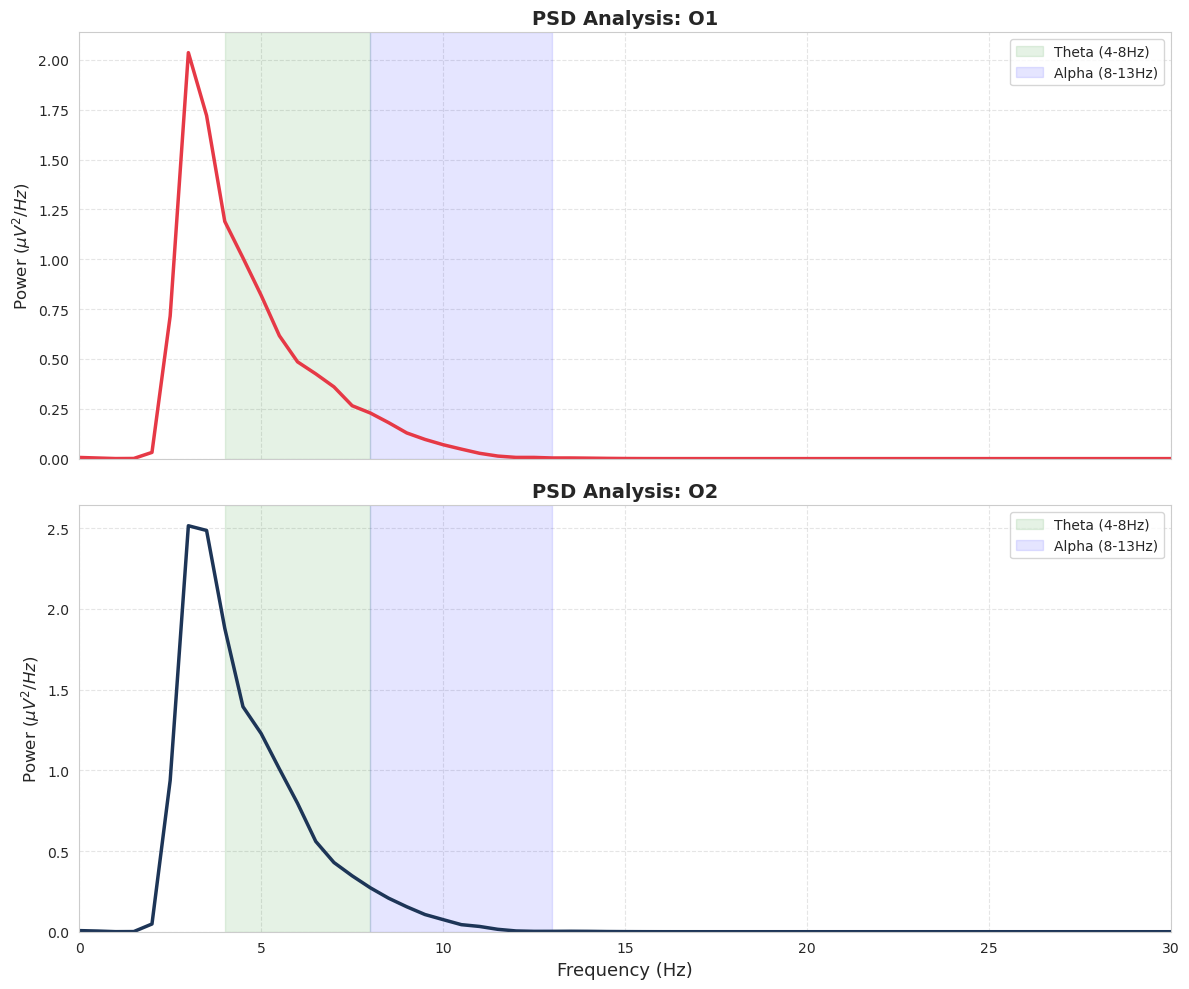

In [148]:
INPUT_FILE = 'ica_window_20k.csv'

plot_psd(processed_path / INPUT_FILE)

### WAVELET FEATURE EXTRACTION

In [149]:
import pywt

In [150]:
def calculate_entropy(coeffs):
    sq_coeffs = np.square(coeffs)
    total_energy = np.sum(sq_coeffs)
    if total_energy == 0:
        return 0
    prob = sq_coeffs / total_energy
    return -np.sum(prob * np.log2(prob + 1e-12))

def extract_wavelet_features_refined(input_file, output_file, fs=125.0):
    try:
        print(f"Loading data from: {input_file}")
        df = pd.read_csv(input_file)
        
        df.columns = [str(col) for col in df.columns]
        eeg_df = df.select_dtypes(include=np.number)
        
        feature_list = []
        
        print("Calculating DWT features (db4, Level 4)...")
        
        for col in eeg_df.columns:
            signal = eeg_df[col].values

            coeffs = pywt.wavedec(signal, 'db4', level=4)

            total_energy = sum([np.sum(np.square(c)) for c in coeffs])
 
            theta_coeffs = coeffs[1]
            alpha_coeffs = coeffs[2]

            theta_energy = np.sum(np.square(theta_coeffs))
            alpha_energy = np.sum(np.square(alpha_coeffs))
            
            features = {
                'Channel': col,
                'Theta_Energy_Abs': theta_energy,
                'Theta_Energy_Rel': theta_energy / total_energy if total_energy > 0 else 0,
                'Theta_Std':        np.std(theta_coeffs),
                'Theta_Entropy':    calculate_entropy(theta_coeffs),

                'Alpha_Energy_Abs': alpha_energy,
                'Alpha_Energy_Rel': alpha_energy / total_energy if total_energy > 0 else 0,
                'Alpha_Std':        np.std(alpha_coeffs),
                'Alpha_Entropy':    calculate_entropy(alpha_coeffs)
            }
            feature_list.append(features)

        result_df = pd.DataFrame(feature_list)
        result_df.to_csv(output_file, index=False)
        
        print(f"Success! Wavelet features saved to: {output_file}")
        return result_df
        
    except Exception as e:
        print(f"Error in Wavelet Extraction: {e}")

In [151]:
INPUT_FILE = 'ica_window_20k.csv'
OUTPUT_FILE = 'wavelet_features.csv'

wavelet_features = extract_wavelet_features_refined(
    input_file=processed_path / INPUT_FILE, 
    output_file=processed_path / OUTPUT_FILE
)

Loading data from: /home/deruka/code-playground/CNN-LSTM/Data_processed/ica_window_20k.csv
Calculating DWT features (db4, Level 4)...
Success! Wavelet features saved to: /home/deruka/code-playground/CNN-LSTM/Data_processed/wavelet_features.csv


### WAVELET FEATURE COMPARISION FOR CHANNEL **O1** AND **O2**

In [152]:
def plot_wavelet_o1_o2_bars(csv_file):
    try:
        df = pd.read_csv(csv_file)

        target_channels = ['O1', 'O2']
        subset = df[df['Channel'].isin(target_channels)]
        
        if subset.empty:
            print(f"Warning: Channels {target_channels} not found in {csv_file}")
            return

        df_melted = subset.melt(id_vars='Channel', var_name='Features', value_name='Value')

        plt.figure(figsize=(14, 7))
        sns.set_style("whitegrid")

        sns.barplot(data=df_melted, x='Features', y='Value', hue='Channel', palette=['#E63946', '#1D3557'])

        plt.title('Wavelet Feature Comparison: O1 vs O2', fontsize=16, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Magnitude / Energy')
        plt.xlabel('Extracted Wavelet Features')
        plt.legend(title='Occipital Channel')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

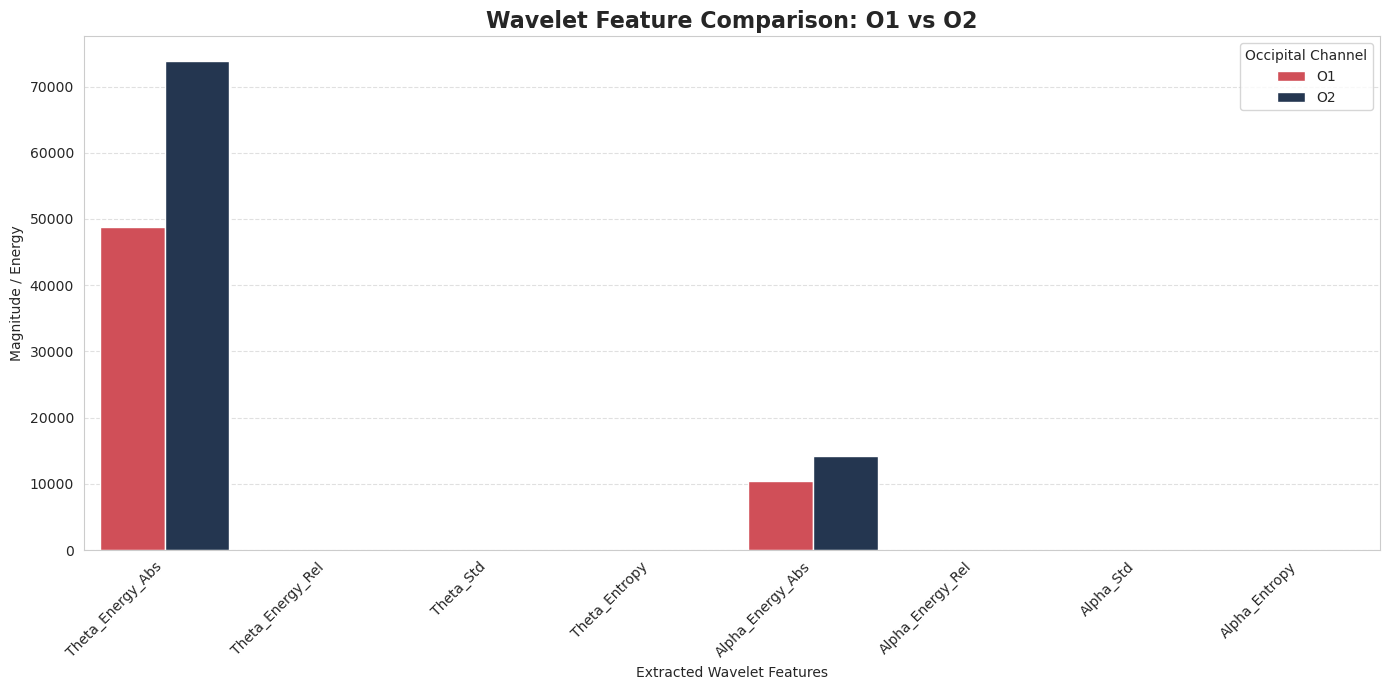

In [153]:
INPUT_FILE = 'wavelet_features.csv'

plot_wavelet_o1_o2_bars(processed_path / INPUT_FILE)

### NORMALIZING THE FEATURES

In [154]:
from sklearn.preprocessing import MinMaxScaler

In [155]:
def normalize_feature_file(input_file, output_file):
    try:
        df = pd.read_csv(input_file)
        
        if 'Channel' in df.columns:
            channel_names = df['Channel']
            features_df = df.drop(columns=['Channel'])
        else:
            channel_names = None
            features_df = df

        scaler = MinMaxScaler(feature_range=(0, 1))

        scaled_values = scaler.fit_transform(features_df)

        df_normalized = pd.DataFrame(
            scaled_values, 
            columns=features_df.columns
        )

        if channel_names is not None:
            df_normalized.insert(0, 'Channel', channel_names.values)

        df_normalized.to_csv(output_file, index=False)
        print(f"Normalized: {input_file} -> {output_file}")
        return df_normalized
    except Exception as e:
        print(f"Error scaling {input_file}: {e}")

In [156]:
INPUT_PSD_FILE = 'psd_features.csv'
OUTPUT_PSD_FILE = 'psd_features_norm.csv'

INPUT_WAVELET_FILE = 'wavelet_features.csv'
OUTPUT_WAVELET_FILE = 'wavelet_features_norm.csv'

psd_norm = normalize_feature_file(processed_path / INPUT_PSD_FILE, processed_path / OUTPUT_PSD_FILE)
wavelet_norm = normalize_feature_file(processed_path / INPUT_WAVELET_FILE, processed_path / OUTPUT_WAVELET_FILE)

Normalized: /home/deruka/code-playground/CNN-LSTM/Data_processed/psd_features.csv -> /home/deruka/code-playground/CNN-LSTM/Data_processed/psd_features_norm.csv
Normalized: /home/deruka/code-playground/CNN-LSTM/Data_processed/wavelet_features.csv -> /home/deruka/code-playground/CNN-LSTM/Data_processed/wavelet_features_norm.csv


### MERGING THE FEATURES TOGETHER

In [157]:
def create_master_normalized_set(wavelet_norm_path, psd_norm_path, output_file):
    try:
        w_norm = pd.read_csv(wavelet_norm_path)
        p_norm = pd.read_csv(psd_norm_path)
        
        master_df = pd.merge(w_norm, p_norm, on='Channel', how='inner')
        
        master_df.to_csv(output_file, index=False)
        
        print(f"Master Normalized Dataset Created: {output_file}")
        print(f"Final shape: {master_df.shape} (Channels x Total Features)")
        return master_df
    except Exception as e:
        print(f"Error merging feature sets: {e}")

In [158]:
INPUT_PSD_NORM_FILE = 'psd_features_norm.csv'
INTPUT_WAVELET_NORM_FILE = 'wavelet_features_norm.csv'

OUTPUT_MASTER_FILE = 'master_features_normalized.csv'

master_normalized_df = create_master_normalized_set(
    processed_path / INTPUT_WAVELET_NORM_FILE,
    processed_path / INPUT_PSD_NORM_FILE,
    processed_path / OUTPUT_MASTER_FILE
)

Master Normalized Dataset Created: /home/deruka/code-playground/CNN-LSTM/Data_processed/master_features_normalized.csv
Final shape: (19, 13) (Channels x Total Features)


### LABELING THE DATASET

In [162]:
FS = 125.0
WINDOW_SEC = 6.0
STRIDE_SEC = 3.0
AUTOCORR_THRESHOLD = 0.2

WINDOW_SAMPLES = int(WINDOW_SEC * FS)
STRIDE_SAMPLES = int(STRIDE_SEC * FS)

In [163]:
def autocorr_decay_time(x, fs, threshold=AUTOCORR_THRESHOLD):
    x = x - np.mean(x)
    ac = np.correlate(x, x, mode='full')
    ac = ac[len(ac)//2:]
    ac /= (ac[0] + 1e-12)

    below = np.where(ac < threshold)[0]
    if len(below) == 0:
        return len(ac) / fs
    return below[0] / fs
    
def create_labeled_cnn_lstm_dataset(input_csv):
    df = pd.read_csv(input_csv)
    eeg_df = df.select_dtypes(include='number')
    data = eeg_df.values

    n_samples, n_channels = data.shape

    windows, taus = [], []

    # ---------- PASS 1: compute tau ----------
    for start in range(0, n_samples - WINDOW_SAMPLES, STRIDE_SAMPLES):
        window = data[start:start + WINDOW_SAMPLES]

        tau_ch = [
            autocorr_decay_time(window[:, ch], FS)
            for ch in range(n_channels)
        ]

        tau = np.median(tau_ch)   # robust aggregation
        windows.append(window.T)  # (channels, time)
        taus.append(tau)

    taus = np.array(taus)

    # ---------- Threshold: binary split ----------
    tau_thresh = np.median(taus)

    print("Temporal depth threshold:")
    print(f"  Short < {tau_thresh:.3f}s")
    print(f"  Mid   ≥ {tau_thresh:.3f}s")
    print("Tau distribution (percentiles):",
          np.percentile(taus, [5, 25, 50, 75, 95]))

    # ---------- PASS 2: label ----------
    X, y = [], []
    for w, tau in zip(windows, taus):
        label = 0 if tau < tau_thresh else 1
        X.append(w)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    print("\nDataset created")
    print(f"X shape: {X.shape}")
    print("Label distribution:",
          dict(zip(*np.unique(y, return_counts=True))))

    return X, y

In [164]:
INPUT_FILE = "ica_training.csv"

X_train, y_train = create_labeled_cnn_lstm_dataset(processed_path / INPUT_FILE)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

Temporal depth threshold:
  Short < 0.048s
  Mid   ≥ 0.048s
Tau distribution (percentiles): [0.04  0.048 0.048 0.048 0.056]

Dataset created
X shape: (635, 19, 750)
Label distribution: {np.int64(0): np.int64(150), np.int64(1): np.int64(485)}
